# H1N1/Flu Vaccine Predictions Project

Andrew Hendricks

## 1. Business Understanding

Whether in terms of [lives lost](https://covid19.who.int/), [mental health](https://www.who.int/news/item/02-03-2022-covid-19-pandemic-triggers-25-increase-in-prevalence-of-anxiety-and-depression-worldwide#:~:text=Wake%2Dup%20call%20to%20all,mental%20health%20services%20and%20support&text=In%20the%20first%20year%20of,Health%20Organization%20(WHO)%20today.), or the [economy](https://healthpolicy.usc.edu/article/covid-19s-total-cost-to-the-economy-in-us-will-reach-14-trillion-by-end-of-2023-new-research/#:~:text=From%202020%20to%202023%2C%20the,dollars%2C%20according%20to%20our%20analysis.), the devastation of the COVID-19 pandemic has been colossal. 

The severity of the COVID-19 crisis highlighted the importance of understanding vaccination patterns. Once scientists developed the vaccine and companies were able to produce it at scale, we saw how influential factors like beliefs, opinions, and politics became in the effort to vaccinate the public. 

Deepening our understanding of the specifics of how an individual's background, opinions, and behaviors relate to whether they decide to get vaccinated can help health officials make data-driven decisions around the most effective ways to protect the public from future pandemics. In this project, I use data from a past pandemic, the H1N1 pandemic of 2009, to create a model that uses information from the National 2009 H1N1 Flu Survey to predict whether people got H1N1 vaccines. I conclude the analysis by offering three recommendations for how public health officials can support future public health efforts.

Because of the nature of the problem, my model predicts whether someone will get an H1N1 vaccine, and I use accuracy as my most important classification metric. There is no domain-specific need for the model to do a better job at avoiding false positives or false negatives, so my goal is to create a model that is as accurate as I can make it.

This analysis uses data from and adapts the prompt from the Driven Data [Flu Shot Competition](https://www.drivendata.org/competitions/66/flu-shot-learning/). The analysis is influenced by the sources listed in the [about the data section](https://www.drivendata.org/competitions/66/flu-shot-learning/page/213/) and the
[data dictionary](https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/) supported the interpretation of categories.  I also relied on sources like StackOverflow and ChatGPT for support with writing some of the code for the project; when I did, I embedded attributions in the cells.

## 2. Data Understanding

Importing libraries and data:

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay, log_loss
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
df = pd.read_csv('./data/training_set_features.csv')
labels = pd.read_csv('./data/training_set_labels.csv')

Merging features and labels:

In [3]:
df = pd.merge(df, labels, on='respondent_id')

Reviewing Basic Data Features:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

Observations: Health insurance, employment industry, and employment occupation have about 50% null values. Several other categories also have null values that account for fewer than 10% of overall records. Most of the columns are numeric data types and the rest are objects. We need to further examine the categories with high null counts to decide how to address the nulls.

In [5]:
df.health_insurance.value_counts(normalize=True)

1.0    0.87972
0.0    0.12028
Name: health_insurance, dtype: float64

In [6]:
df.employment_industry.value_counts(normalize=True)

fcxhlnwr    0.184496
wxleyezf    0.134858
ldnlellj    0.092024
pxcmvdjn    0.077521
atmlpfrs    0.069223
arjwrbjb    0.065112
xicduogh    0.063617
mfikgejo    0.045900
vjjrobsf    0.039396
rucpziij    0.039097
xqicxuve    0.038200
saaquncn    0.025267
cfqqtusy    0.024295
nduyfdeo    0.021380
mcubkhph    0.020558
wlfvacwt    0.016072
dotnnunm    0.015026
haxffmxo    0.011064
msuufmds    0.009270
phxvnwax    0.006653
qnlwzans    0.000972
Name: employment_industry, dtype: float64

In [7]:
df.employment_occupation.value_counts(normalize=True)

xtkaffoo    0.134320
mxkfnird    0.113999
emcorrxb    0.095943
cmhcxjea    0.094206
xgwztkwe    0.081741
hfxkjkmi    0.057868
qxajmpny    0.041399
xqwwgdyp    0.036640
kldqjyjy    0.035431
uqqtjvyb    0.034147
tfqavkke    0.029312
ukymxvdu    0.028103
vlluhbov    0.026743
oijqvulv    0.025988
ccgxvspp    0.025761
bxpfxfdn    0.025006
haliazsg    0.022362
rcertsgn    0.020851
xzmlyyjv    0.018735
dlvbwzss    0.017149
hodpvpew    0.015714
dcjcmpih    0.011181
pvmttkik    0.007403
Name: employment_occupation, dtype: float64

Analysis: Approximately 88% of the known health insurance values are class 1, so I am going to use a simple imputer set to 'most frequent' to address the null values in that column as opposed to removing the column or the records with null values. The employment industry and employment occupation columns contain random strings, so analyzing them would not provide any useful information to public health officials. I am going to drop those columns. I will use simple imputer set to most frequent for the remaining columns that have fewer than 10% null values. The data dictionary shows that records in the hhs_geo_region category are also random strings, so I am going to drop that column, too.

In [8]:
df.drop(['employment_industry','employment_occupation','hhs_geo_region'],axis=1,inplace=True)

In [9]:
df.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,1.000000,1.000000


In [10]:
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Female,Below Poverty,Not Married,Own,Not in Labor Force,Non-MSA,0.0,0.0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Male,Below Poverty,Not Married,Rent,Employed,"MSA, Not Principle City",0.0,0.0,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,"MSA, Not Principle City",2.0,0.0,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Female,Below Poverty,Not Married,Rent,Not in Labor Force,"MSA, Principle City",0.0,0.0,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Female,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Not Principle City",1.0,0.0,0,0


Observations: Despite the fact that the majority of columns contain numeric data types, virtually all of the columns can be treated as categorical because they contain discrete responses to survey questions. Many of the columns contain binaries and the rest contain survey responses with a maximum of five response options.

Analysis: I will treat all columns as categoricals and will use one-hot encoding for columns that are not already binary. I will not include Respondent ID in the analysis, but I will include information related to the seasonal flu because it could relate to behavior around H1N1 vaccination.

Checking for data imbalance in the target:

In [11]:
df.h1n1_vaccine.value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

In [12]:
df.h1n1_vaccine.value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

Analysis: Logistic regression can work with data imbalance up to a threshold of about 85/15, so I am going to tolerate the 79/21 ratio present in this data. Based on the volume of records in class zero, the dummy classifier should get an accuracy score of 0.787546 by predicting that each record is a member of class zero. That will be the minimum score to beat with the model.

## 3. Data Preparation

Defining independent and dependent variables and performing train-test split:

In [13]:
df1 = df.copy()

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [15]:
X = df1.drop(['respondent_id','h1n1_vaccine','seasonal_vaccine'], axis=1)
y = df1['h1n1_vaccine']

Explanation: I am dropping seasonal vaccine from the independent variables because it may help the model's predictions, the purpose of this exercise is to predict vaccination behavior without knowing vaccination status. Including seasonal flu vaccine status in the model would therefore compromise the results by undermining the purpose of the analysis.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
X_train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children
25194,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,12 Years,White,Female,NaN,Not Married,Own,Not in Labor Force,Non-MSA,1.0,1.0
14006,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,Some College,White,Female,NaN,Married,NaN,Employed,"MSA, Not Principle City",2.0,1.0
11285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,College Graduate,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,"MSA, Principle City",0.0,1.0
2900,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,College Graduate,White,Male,Below Poverty,Not Married,Own,Employed,"MSA, Not Principle City",0.0,0.0
19083,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,NaN,White,Female,NaN,NaN,NaN,NaN,"MSA, Not Principle City",NaN,NaN


Differentiating between binary columns and columns that need OHE; creating initial pipelines:

In [18]:
ohecols = ['household_adults','household_children','age_group','education','race','sex','income_poverty',
           'marital_status', 'rent_or_own','employment_status','census_msa', 'h1n1_concern', 'h1n1_knowledge',
           'opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_h1n1_sick_from_vacc','opinion_seas_vacc_effective',
           'opinion_seas_risk','opinion_seas_sick_from_vacc']

In [19]:
bincols = ['behavioral_antiviral_meds','behavioral_avoidance','behavioral_face_mask','behavioral_wash_hands',
           'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 
           'doctor_recc_seasonal','chronic_med_condition','child_under_6_months','health_worker', 'health_insurance']

In [20]:
onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')

ohe_sub = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', onehot)
])

In [21]:
bin_sub = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent'))
])

In [22]:
CT = ColumnTransformer(transformers=[
    ('onehot', ohe_sub, ohecols),
    ('binary', bin_sub, bincols)
])

bin_sub = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent'))
])

## 4. Modeling

### 4.1 Baseline Model: Dummy

Using dummy classifier to create baseline predictions:

In [23]:
dum_pipe = Pipeline(steps=[
    ('ct', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [24]:
dum_pipe.fit(X_train, y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['household_adults',
                                                   'household_children',
                                                   'age_group', 'education',
                                                   'race', 'sex',
                                                   'income_poverty',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'census...
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1',
                                                   'doctor_recc_seasonal',
                                                   'chronic_med_condition',
                                                   'child_under_6_months',
                                                   'health_worker',
                                                   'health_insurance'])])),
                ('dummy', DummyClassifier(strategy='most_frequent'))])

Classification metrics and visualizations:

In [25]:
print(classification_report(y_test, dum_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      5260
           1       0.00      0.00      0.00      1417

    accuracy                           0.79      6677
   macro avg       0.39      0.50      0.44      6677
weighted avg       0.62      0.79      0.69      6677



C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

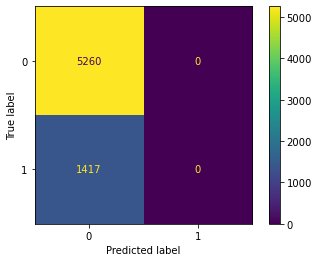

In [26]:
ConfusionMatrixDisplay.from_estimator(dum_pipe, X_test, y_test);

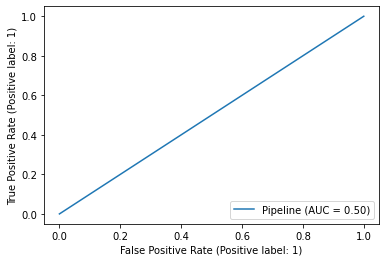

In [27]:
RocCurveDisplay.from_estimator(dum_pipe, X_test, y_test);

In [28]:
log_loss(y_test, dum_pipe.predict_proba(X_test))

7.649222233395088

Analysis: As expected, the dummy classifier achieved an accuracy rate of 79%. Its precision score, recall score, and F1 score for predicting class 1 were all 0 because it predicts that every data point comes from class zero. The confusion matrix visualizes the dummy classifier's methodology, and the ROC curve shows through the AUC = .5 that the correctness of the model's predictions is based on chance. The log loss score further confirms the unreliability of the dummy classifier.

### 4.2 First Model: Logistic Regression on All Categories

Now that I have a score to beat from the dummy classifier, next I create a first simple model by performing logistic regression on all categories. The purpose of this is to create a baseline for future iterations of the model, which will incorporate feature selection and feature engineering based on the results of this first simple model.

In [103]:
fsm_pipe = Pipeline(steps=[
    ('ct', CT),
    ('fsm', LogisticRegression(max_iter=1000))
])

In [104]:
fsm_pipe.fit(X_train, y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['household_adults',
                                                   'household_children',
                                                   'age_group', 'education',
                                                   'race', 'sex',
                                                   'income_poverty',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'census...
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1',
                                                   'doctor_recc_seasonal',
                                                   'chronic_med_condition',
                                                   'child_under_6_months',
                                                   'health_worker',
                                                   'health_insurance'])])),
                ('fsm', LogisticRegression(max_iter=1000))])

First, I take a look at the cross validation score for 5 folds.

In [105]:
cross_val_score(fsm_pipe, X_train, y_train, cv=5)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse

array([0.83125312, 0.83250125, 0.83999001, 0.8349975 , 0.8349975 ])

All of the folds had accuracy scores of around 83% to 84%, which beats out the dummy regressor. Next, I need to see how it performs on the test data.

Classification metrics and visualizations:

In [31]:
print(classification_report(y_test, fsm_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      5260
           1       0.71      0.43      0.53      1417

    accuracy                           0.84      6677
   macro avg       0.78      0.69      0.72      6677
weighted avg       0.83      0.84      0.82      6677



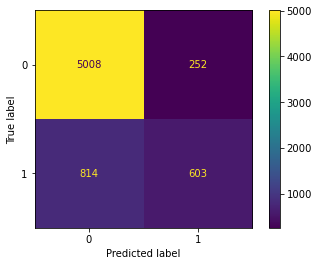

In [32]:
ConfusionMatrixDisplay.from_estimator(fsm_pipe, X_test, y_test);

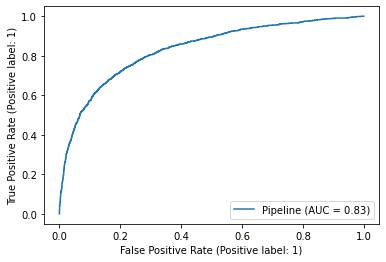

In [33]:
RocCurveDisplay.from_estimator(fsm_pipe, X_test, y_test);

In [34]:
log_loss(y_test, fsm_pipe.predict_proba(X_test))

0.38017037757694067

Analysis: Our first simple model was able to outperform the dummy classifier in virtually every classification metric. The accuracy score improved from 79% to 84%; recall, precision, and F1 all improved; AUC rose from .5 to .83; and log loss decreased from 7.33 to .38. Because the cross validation scores were nearly identical to the accuracy score on the test data, it looks like the model is not substantially over or under fit. The consensus of all of these metrics shows that the first simple model made better predictions than the dummy.

Next, I used grid search to optimize first simple model.  I used resources from [here](https://levelup.gitconnected.com/a-comprehensive-analysis-of-hyperparameter-optimization-in-logistic-regression-models-521564c1bfc0) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to help guide my selection of hyperparameters and parameters.

In [35]:
params = {
    'fsm__max_iter' : [10, 100, 1000, 10000],
    'fsm__C' : [0.0001, 0.001, 0.01, 0.1, 1],
    'fsm__tol' : [0.0001,0.001,0.01,0.1],
    'fsm__penalty' : ['l2','none'],
    'fsm__class_weight' : [None,'balanced']
}

In [36]:
gs = GridSearchCV(
    estimator = fsm_pipe,
    param_grid = params,
    cv = 5,
    verbose = 1
)

In the following cells, I comment out the following cells to avoid running a multihour gridsearch when running the notebook. I recorded the results in markdowns below the cells.

In [37]:
#gs.fit(X_train, y_train)

In [38]:
#gs.best_params_

FSM BEST PARAMETERS:

{'fsm__C': 1,
 'fsm__class_weight': None,
 'fsm__max_iter': 100,
 'fsm__penalty': 'l2',
 'fsm__tol': 0.0001}

In [39]:
#gs.best_estimator_

FSM BEST ESTIMATORS

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['household_adults',
                                                   'household_children',
                                                   'age_group', 'education',
                                                   'race', 'sex',
                                                   'income_poverty',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'census...
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1',
                                                   'doctor_recc_seasonal',
                                                   'chronic_med_condition',
                                                   'child_under_6_months',
                                                   'health_worker',
                                                   'health_insurance'])])),
                ('fsm', LogisticRegression(C=1))])

In [40]:
fsm_optimized_pipe = Pipeline(steps=[
    ('ct', CT),
    ('fsm', LogisticRegression(C=1, max_iter=100, penalty='l2',tol=.0001))
])

In [41]:
fsm_optimized_pipe.fit(X_train, y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['household_adults',
                                                   'household_children',
                                                   'age_group', 'education',
                                                   'race', 'sex',
                                                   'income_poverty',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'census...
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1',
                                                   'doctor_recc_seasonal',
                                                   'chronic_med_condition',
                                                   'child_under_6_months',
                                                   'health_worker',
                                                   'health_insurance'])])),
                ('fsm', LogisticRegression(C=1))])

In [42]:
print(classification_report(y_test, fsm_optimized_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      5260
           1       0.71      0.43      0.53      1417

    accuracy                           0.84      6677
   macro avg       0.78      0.69      0.72      6677
weighted avg       0.83      0.84      0.82      6677



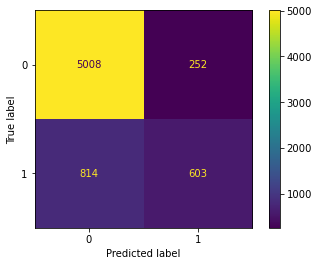

In [43]:
ConfusionMatrixDisplay.from_estimator(fsm_optimized_pipe, X_test, y_test);

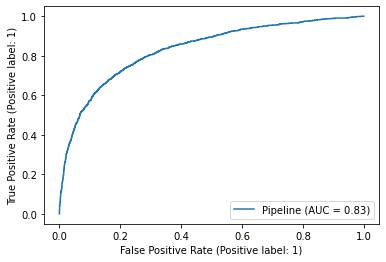

In [44]:
RocCurveDisplay.from_estimator(fsm_optimized_pipe, X_test, y_test);

In [45]:
log_loss(y_test, fsm_optimized_pipe.predict_proba(X_test))

0.38017037757694067

Analysis: Using the tuned hyperparameters from the grid search did not alter the results of the first simple model in any significant way. In the following section, I create a second model that only uses the variables with the strongest coefficients to see if that can improve the results.

### 4.3 Second Model: Feature Selection

For the second model, I use lasso regularization to determine which variables to include in and exclude from my model that incorporates feature selection. First, I get the feature names after one hot encoding and concatenate them with the binary column names to get a list of all the columns after going through the column transformer. Next, I use lasso regularization to find which coefficients drop to zero. I create a list of selected columns from the columns with non-zero values and then provide the second model with only those features.

I use the following code to get the column names out of the pipeline after OHE. While I wrote all of the code myself, I used Stack Overflow and ChatGPT to support my thought process.

In [46]:
CT1 = ColumnTransformer(transformers=[
    ('ohe_impute', SimpleImputer(strategy='most_frequent'), ohecols),
    ('ohe', onehot, ohecols),
    ('bin_impute', SimpleImputer(strategy='most_frequent'), bincols)
])

In [47]:
X1 = X_train.dropna()
CT1.fit(X1)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('ohe_impute',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['household_adults', 'household_children',
                                  'age_group', 'education', 'race', 'sex',
                                  'income_poverty', 'marital_status',
                                  'rent_or_own', 'employment_status',
                                  'census_msa', 'h1n1_concern',
                                  'h1n1_knowledge',
                                  'opinion_h1n1_vacc_effective',
                                  'opinion_h1n1_risk',
                                  'opinion_h1n1_sick_from...
                                ('bin_impute',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1',
                                  'doctor_recc_seasonal',
                                  'chronic_med_condition',
                                  'child_under_6_months', 'health_worker',
                                  'health_insurance'])])

In [48]:
categorical_feature_names = CT1.named_transformers_['ohe'].get_feature_names_out(input_features=ohecols)

In [49]:
categorical_feature_names

array(['household_adults_0.0', 'household_adults_1.0',
       'household_adults_2.0', 'household_adults_3.0',
       'household_children_0.0', 'household_children_1.0',
       'household_children_2.0', 'household_children_3.0',
       'age_group_18 - 34 Years', 'age_group_35 - 44 Years',
       'age_group_45 - 54 Years', 'age_group_55 - 64 Years',
       'age_group_65+ Years', 'education_12 Years',
       'education_< 12 Years', 'education_College Graduate',
       'education_Some College', 'race_Black', 'race_Hispanic',
       'race_Other or Multiple', 'race_White', 'sex_Female', 'sex_Male',
       'income_poverty_<= $75,000, Above Poverty',
       'income_poverty_> $75,000', 'income_poverty_Below Poverty',
       'marital_status_Married', 'marital_status_Not Married',
       'rent_or_own_Own', 'rent_or_own_Rent',
       'employment_status_Employed',
       'employment_status_Not in Labor Force',
       'employment_status_Unemployed',
       'census_msa_MSA, Not Principle  City',
    

I recorded this record of the feature names because they are essential to my subsequent analysis.

['household_adults_0.0', 'household_adults_1.0',
       'household_adults_2.0', 'household_adults_3.0',
       'household_children_0.0', 'household_children_1.0',
       'household_children_2.0', 'household_children_3.0',
       'age_group_18 - 34 Years', 'age_group_35 - 44 Years',
       'age_group_45 - 54 Years', 'age_group_55 - 64 Years',
       'age_group_65+ Years', 'education_12 Years',
       'education_< 12 Years', 'education_College Graduate',
       'education_Some College', 'race_Black', 'race_Hispanic',
       'race_Other or Multiple', 'race_White', 'sex_Female', 'sex_Male',
       'income_poverty_<= $75,000, Above Poverty',
       'income_poverty_> $75,000', 'income_poverty_Below Poverty',
       'marital_status_Married', 'marital_status_Not Married',
       'rent_or_own_Own', 'rent_or_own_Rent',
       'employment_status_Employed',
       'employment_status_Not in Labor Force',
       'employment_status_Unemployed',
       'census_msa_MSA, Not Principle  City',
       'census_msa_MSA, Principle City', 'census_msa_Non-MSA',
       'h1n1_concern_0.0', 'h1n1_concern_1.0', 'h1n1_concern_2.0',
       'h1n1_concern_3.0', 'h1n1_knowledge_0.0', 'h1n1_knowledge_1.0',
       'h1n1_knowledge_2.0', 'opinion_h1n1_vacc_effective_1.0',
       'opinion_h1n1_vacc_effective_2.0',
       'opinion_h1n1_vacc_effective_3.0',
       'opinion_h1n1_vacc_effective_4.0',
       'opinion_h1n1_vacc_effective_5.0', 'opinion_h1n1_risk_1.0',
       'opinion_h1n1_risk_2.0', 'opinion_h1n1_risk_3.0',
       'opinion_h1n1_risk_4.0', 'opinion_h1n1_risk_5.0',
       'opinion_h1n1_sick_from_vacc_1.0',
       'opinion_h1n1_sick_from_vacc_2.0',
       'opinion_h1n1_sick_from_vacc_3.0',
       'opinion_h1n1_sick_from_vacc_4.0',
       'opinion_h1n1_sick_from_vacc_5.0',
       'opinion_seas_vacc_effective_1.0',
       'opinion_seas_vacc_effective_2.0',
       'opinion_seas_vacc_effective_3.0',
       'opinion_seas_vacc_effective_4.0',
       'opinion_seas_vacc_effective_5.0', 'opinion_seas_risk_1.0',
       'opinion_seas_risk_2.0', 'opinion_seas_risk_3.0',
       'opinion_seas_risk_4.0', 'opinion_seas_risk_5.0',
       'opinion_seas_sick_from_vacc_1.0',
       'opinion_seas_sick_from_vacc_2.0',
       'opinion_seas_sick_from_vacc_3.0',
       'opinion_seas_sick_from_vacc_4.0',
       'opinion_seas_sick_from_vacc_5.0']

In [50]:
allcols = list(categorical_feature_names) + bincols

In [51]:
lasso = LogisticRegression(penalty='l1', solver='liblinear')

fsm_lasso_pipe = Pipeline(steps=[
    ('ct', CT),
    ('fsm', lasso)
])

In [52]:
fsm_lasso_pipe.fit(X_train, y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['household_adults',
                                                   'household_children',
                                                   'age_group', 'education',
                                                   'race', 'sex',
                                                   'income_poverty',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'census...
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1',
                                                   'doctor_recc_seasonal',
                                                   'chronic_med_condition',
                                                   'child_under_6_months',
                                                   'health_worker',
                                                   'health_insurance'])])),
                ('fsm', LogisticRegression(penalty='l1', solver='liblinear'))])

In [53]:
lassolist = list(zip(allcols,fsm_lasso_pipe.named_steps['fsm'].coef_[0]))
sorted(lassolist, key=lambda x: x[1])

[('opinion_h1n1_risk_1.0', -1.1565752629861084),
 ('opinion_h1n1_vacc_effective_2.0', -0.9251271868194457),
 ('opinion_h1n1_vacc_effective_1.0', -0.9094489193667685),
 ('opinion_seas_risk_1.0', -0.7150652717499224),
 ('opinion_h1n1_risk_2.0', -0.6734118061114726),
 ('opinion_h1n1_vacc_effective_3.0', -0.5291491588948228),
 ('opinion_seas_sick_from_vacc_3.0', -0.4836986526463861),
 ('opinion_seas_vacc_effective_1.0', -0.43169643641576533),
 ('doctor_recc_seasonal', -0.4218820688061465),
 ('opinion_h1n1_sick_from_vacc_3.0', -0.420164480348911),
 ('opinion_h1n1_risk_3.0', -0.37711025435676737),
 ('opinion_seas_vacc_effective_2.0', -0.35003063597310485),
 ('opinion_seas_sick_from_vacc_5.0', -0.3263994440645598),
 ('age_group_35 - 44 Years', -0.30293527454771274),
 ('opinion_seas_risk_2.0', -0.2925442023512047),
 ('education_< 12 Years', -0.2866811178226406),
 ('race_Black', -0.28110864610931097),
 ('age_group_45 - 54 Years', -0.26935215628058784),
 ('age_group_18 - 34 Years', -0.2455990516

Analysis: Using Lasso regularization dropped the coefficients of 20 variables to 0. I remove these variables for the second model.

In [54]:
categorical_names = CT1.named_transformers_['ohe'].get_feature_names()

In [55]:
allcols2 = list(categorical_names) + bincols

In [56]:
lassolist2 = list(zip(allcols2,fsm_lasso_pipe.named_steps['fsm'].coef_[0]))
sorted(lassolist2, key=lambda x: x[1])

In [57]:
# Code adapted from ChatGPT

non_zero_coefficients = [var for var, coef in lassolist if coef != 0]

In [58]:
non_zero_coefficients

['household_adults_2.0',
 'household_adults_3.0',
 'household_children_1.0',
 'household_children_2.0',
 'household_children_3.0',
 'age_group_18 - 34 Years',
 'age_group_35 - 44 Years',
 'age_group_45 - 54 Years',
 'age_group_65+ Years',
 'education_12 Years',
 'education_< 12 Years',
 'education_College Graduate',
 'race_Black',
 'race_Other or Multiple',
 'race_White',
 'sex_Female',
 'sex_Male',
 'income_poverty_<= $75,000, Above Poverty',
 'income_poverty_Below Poverty',
 'marital_status_Not Married',
 'rent_or_own_Own',
 'rent_or_own_Rent',
 'employment_status_Employed',
 'employment_status_Unemployed',
 'census_msa_MSA, Not Principle  City',
 'census_msa_Non-MSA',
 'h1n1_concern_0.0',
 'h1n1_concern_2.0',
 'h1n1_concern_3.0',
 'h1n1_knowledge_0.0',
 'h1n1_knowledge_1.0',
 'opinion_h1n1_vacc_effective_1.0',
 'opinion_h1n1_vacc_effective_2.0',
 'opinion_h1n1_vacc_effective_3.0',
 'opinion_h1n1_vacc_effective_5.0',
 'opinion_h1n1_risk_1.0',
 'opinion_h1n1_risk_2.0',
 'opinion_h1n1_

In [59]:
X_train.shape

(20030, 32)

In [60]:
X_train_encoded = CT.fit_transform(X_train)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=allcols)
X_train_encoded_df

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,household_adults_0.0,household_adults_1.0,household_adults_2.0,household_adults_3.0,household_children_0.0,household_children_1.0,household_children_2.0,household_children_3.0,age_group_18 - 34 Years,age_group_35 - 44 Years,...,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20025,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
20026,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
20027,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
20028,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0


In [61]:
X_test.shape

(6677, 32)

In [62]:
X_test_encoded = CT.transform(X_test)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=allcols)
X_test_encoded_df

,household_adults_0.0,household_adults_1.0,household_adults_2.0,household_adults_3.0,household_children_0.0,household_children_1.0,household_children_2.0,household_children_3.0,age_group_18 - 34 Years,age_group_35 - 44 Years,...,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6672,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6673,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6674,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
6675,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [63]:
CT2 = ColumnTransformer(transformers=[
    ('impute', SimpleImputer(strategy='most_frequent'), non_zero_coefficients)
], remainder='drop')

In [98]:
sm_pipe = Pipeline(steps=[
    ('ct', CT2),
    ('sm', LogisticRegression(max_iter=1000))
])

In [99]:
sm_pipe.fit(X_train_encoded_df, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['household_adults_2.0',
                                                   'household_adults_3.0',
                                                   'household_children_1.0',
                                                   'household_children_2.0',
                                                   'household_children_3.0',
                                                   'age_group_18 - 34 Years',
                                                   'age_group_35 - 44 Years',
                                                   'age_group_45 - 54 Years',
                                                   'age_group_65+ Years',
                                                   'education_12 Years',
                                                   'education_< 12...
                                                   'Above Poverty',
                                                   'income_poverty_Below '
                                                   'Poverty',
                                                   'marital_status_Not Married',
                                                   'rent_or_own_Own',
                                                   'rent_or_own_Rent',
                                                   'employment_status_Employed',
                                                   'employment_status_Unemployed',
                                                   'census_msa_MSA, Not '
                                                   'Principle  City',
                                                   'census_msa_Non-MSA',
                                                   'h1n1_concern_0.0',
                                                   'h1n1_concern_2.0',
                                                   'h1n1_concern_3.0',
                                                   'h1n1_knowledge_0.0', ...])])),
                ('sm', LogisticRegression(max_iter=1000))])

In [100]:
cross_val_score(sm_pipe, X_train_encoded_df, y_train, cv=5)

array([0.83125312, 0.8330005 , 0.83924114, 0.83524713, 0.83524713])

In [101]:
print(classification_report(y_test, sm_pipe.predict(X_test_encoded_df)))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      5260
           1       0.71      0.43      0.53      1417

    accuracy                           0.84      6677
   macro avg       0.78      0.69      0.72      6677
weighted avg       0.83      0.84      0.83      6677



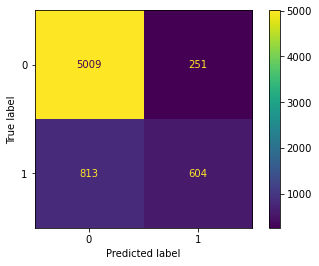

In [67]:
ConfusionMatrixDisplay.from_estimator(sm_pipe, X_test_encoded_df, y_test);

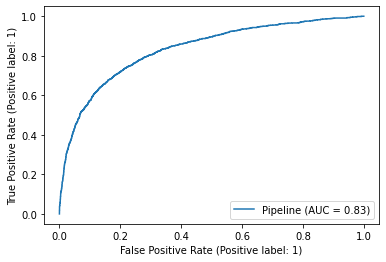

In [68]:
RocCurveDisplay.from_estimator(sm_pipe, X_test_encoded_df, y_test);

In [69]:
log_loss(y_test, sm_pipe.predict_proba(X_test_encoded_df))

0.38012228820568356

Analysis: Just like the first simple model, the second model with selected features predicted with an accuracy score of 84%. Precision, recall, and F1 score were also identical. The cross-validation scores were all around 83%, which suggests that the model may be slightly underfit. I will try to tune the model using grid search.

In [70]:
params1 = {
    'sm__max_iter' : [10, 100, 1000, 10000],
    'sm__C' : [0.0001, 0.001, 0.01, 0.1, 1],
    'sm__tol' : [0.0001,0.001,0.01,0.1],
    'sm__penalty' : ['l2','none'],
    'sm__class_weight' : [None,'balanced']
}

In [71]:
gs1 = GridSearchCV(
    estimator = sm_pipe,
    param_grid = params1,
    cv = 5,
    verbose = 1
)

In [72]:
# I comment this out to avoid running the grid search again

# gs1.fit(X_train_encoded_df, y_train)

In [73]:
# I comment this out to avoid running the grid search again

#gs1.best_params_

Best params:

{'sm__C': 1,
 'sm__class_weight': None,
 'sm__max_iter': 1000,
 'sm__penalty': 'l2',
 'sm__tol': 0.0001}

In [74]:
# I comment this out to avoid running the grid search again

#gs1.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['household_adults_2.0',
                                                   'household_adults_3.0',
                                                   'household_children_1.0',
                                                   'household_children_2.0',
                                                   'household_children_3.0',
                                                   'age_group_18 - 34 Years',
                                                   'age_group_35 - 44 Years',
                                                   'age_group_45 - 54 Years',
                                                   'age_group_65+ Years',
                                                   'education_12 Years',
                                                   'education_< 12...
                                                   'marital_status_Not Married',
                                                   'rent_or_own_Rent',
                                                   'employment_status_Employed',
                                                   'employment_status_Unemployed',
                                                   'census_msa_MSA, Not '
                                                   'Principle  City',
                                                   'census_msa_Non-MSA',
                                                   'h1n1_concern_0.0',
                                                   'h1n1_concern_2.0',
                                                   'h1n1_concern_3.0',
                                                   'h1n1_knowledge_0.0',
                                                   'h1n1_knowledge_1.0',
                                                   'opinion_h1n1_vacc_effective_1.0', ...])])),
                ('sm', LogisticRegression(C=1, max_iter=1000))])

In [75]:
sm_optimized_pipe = Pipeline(steps=[
    ('ct', CT2),
    ('sm', LogisticRegression(C=1, max_iter=1000, penalty='l2',tol=.0001))
])

In [76]:
sm_optimized_pipe.fit(X_train_encoded_df, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['household_adults_2.0',
                                                   'household_adults_3.0',
                                                   'household_children_1.0',
                                                   'household_children_2.0',
                                                   'household_children_3.0',
                                                   'age_group_18 - 34 Years',
                                                   'age_group_35 - 44 Years',
                                                   'age_group_45 - 54 Years',
                                                   'age_group_65+ Years',
                                                   'education_12 Years',
                                                   'education_< 12...
                                                   'Above Poverty',
                                                   'income_poverty_Below '
                                                   'Poverty',
                                                   'marital_status_Not Married',
                                                   'rent_or_own_Own',
                                                   'rent_or_own_Rent',
                                                   'employment_status_Employed',
                                                   'employment_status_Unemployed',
                                                   'census_msa_MSA, Not '
                                                   'Principle  City',
                                                   'census_msa_Non-MSA',
                                                   'h1n1_concern_0.0',
                                                   'h1n1_concern_2.0',
                                                   'h1n1_concern_3.0',
                                                   'h1n1_knowledge_0.0', ...])])),
                ('sm', LogisticRegression(C=1, max_iter=1000))])

In [77]:
print(classification_report(y_test, sm_optimized_pipe.predict(X_test_encoded_df)))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      5260
           1       0.71      0.43      0.53      1417

    accuracy                           0.84      6677
   macro avg       0.78      0.69      0.72      6677
weighted avg       0.83      0.84      0.83      6677



Analysis: Once again, using the parameters recommended by the grid search did not have any noticeable impact on the classification metrics.

### 4.4 Third Model: Feature Selection, Polynomial Features, and Ridge Regularization

For my final model, I will see if we can improve the accuracy by using polynomial features to overfit the model to the train data and then using Ridge regularization to reduce the overfitting.

In [107]:
tm_pipe = Pipeline(steps=[
    ('ct', CT2),
    ('pf', PolynomialFeatures(degree=2)),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])

In [108]:
tm_pipe.fit(X_train_encoded_df, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['household_adults_2.0',
                                                   'household_adults_3.0',
                                                   'household_children_1.0',
                                                   'household_children_2.0',
                                                   'household_children_3.0',
                                                   'age_group_18 - 34 Years',
                                                   'age_group_35 - 44 Years',
                                                   'age_group_45 - 54 Years',
                                                   'age_group_65+ Years',
                                                   'education_12 Years',
                                                   'education_< 12...
                                                   'income_poverty_Below '
                                                   'Poverty',
                                                   'marital_status_Not Married',
                                                   'rent_or_own_Own',
                                                   'rent_or_own_Rent',
                                                   'employment_status_Employed',
                                                   'employment_status_Unemployed',
                                                   'census_msa_MSA, Not '
                                                   'Principle  City',
                                                   'census_msa_Non-MSA',
                                                   'h1n1_concern_0.0',
                                                   'h1n1_concern_2.0',
                                                   'h1n1_concern_3.0',
                                                   'h1n1_knowledge_0.0', ...])])),
                ('pf', PolynomialFeatures()),
                ('lr', LogisticRegression(max_iter=1000))])

In [111]:
cross_val_score(tm_pipe,X_train_encoded_df, y_train,cv=5)

array([0.81402896, 0.8222666 , 0.82051922, 0.82176735, 0.81502746])

In [80]:
print(classification_report(y_test, tm_pipe.predict(X_test_encoded_df)))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      5260
           1       0.63      0.49      0.55      1417

    accuracy                           0.83      6677
   macro avg       0.75      0.71      0.72      6677
weighted avg       0.82      0.83      0.82      6677



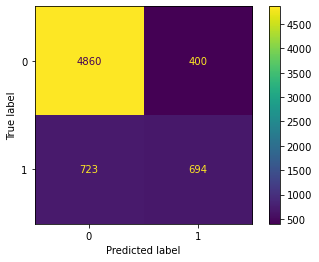

In [81]:
ConfusionMatrixDisplay.from_estimator(tm_pipe, X_test_encoded_df, y_test);

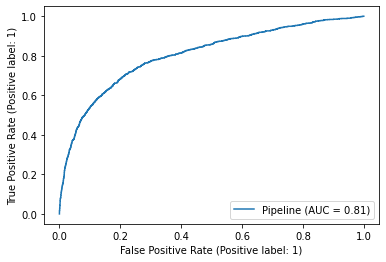

In [82]:
RocCurveDisplay.from_estimator(tm_pipe, X_test_encoded_df, y_test);

In [83]:
log_loss(y_test, tm_pipe.predict_proba(X_test_encoded_df))

0.42522764337547314

Analysis: Using feature selection, polynomial features, and Ridge regularization decreased the accuracy score by 1% when compared to using logistic regression on all columns or to using logistic regression on selected features. It also performed worse in terms of log loss and precision. Once again, the cross-validation scores were slightly lower than the scores for the test data, suggesting the model may be slightly underfit.

Note: When I ran a grid search on a similar model, it ran for 14 hours without finishing. I decided not to use a grid search to try to tune this model for practical reasons, but that could be a next step.

## 5. Conclusions

Overall, the most accurate models were the first model and the second model, which had accuracy scores of 84%. The next best was the third model, which had an accuracy score of 83%. All of these models beat the baseline dummy classifier, which had an accuracy score of 79%. In the following code, I use the first model to investigate the strength of the coefficients for each variable. To conclude the project, I use what I learn from the analysis of coefficients to create recommendations for health care officials.

In [84]:
coeflist = list(zip(allcols,fsm_pipe.named_steps['fsm'].coef_[0]))

In [85]:
# This line of code is adapted from ChatGPT

sorted(coeflist, key=lambda x: x[1])

[('opinion_h1n1_risk_1.0', -0.8427428763566939),
 ('opinion_h1n1_vacc_effective_1.0', -0.6885830463762175),
 ('opinion_h1n1_vacc_effective_2.0', -0.6798861558772609),
 ('opinion_seas_risk_1.0', -0.5767674662184954),
 ('opinion_seas_sick_from_vacc_3.0', -0.5393887171182331),
 ('doctor_recc_seasonal', -0.4290814003620131),
 ('opinion_h1n1_sick_from_vacc_3.0', -0.419549085778368),
 ('opinion_seas_vacc_effective_1.0', -0.41410920903630843),
 ('opinion_h1n1_risk_2.0', -0.3585808280112189),
 ('race_Black', -0.3322774240538997),
 ('education_< 12 Years', -0.31332604729197333),
 ('opinion_seas_vacc_effective_2.0', -0.3036542455449231),
 ('opinion_h1n1_vacc_effective_3.0', -0.2850958758199145),
 ('h1n1_concern_3.0', -0.2784178176474338),
 ('sex_Female', -0.2687249882876903),
 ('marital_status_Not Married', -0.25234027589430924),
 ('age_group_35 - 44 Years', -0.2485485626183191),
 ('opinion_seas_sick_from_vacc_5.0', -0.22785077654720423),
 ('rent_or_own_Rent', -0.2227134052459255),
 ('age_group_

In the following code, I concatenate the column names after one hot encoding with the names of the binary columns. Then I create I zip the column names together with the coefficients from fsm.

Because the coefficients represent log odds, which have a low level of interpretability, I decided to convert them to probabilities. I used both [Stack Overflow](https://stackoverflow.com/questions/48465737/how-to-convert-log-probability-into-simple-probability-between-0-and-1-values-us#:~:text=You%20have%20to%20take%20exponent,where%20p%20are%20the%20probabilities.) and [Stack Exchange](https://stats.stackexchange.com/questions/363791/logit-interpreting-coefficients-as-probabilities) for support. First, I use np.exp to transform the log odds into odds. Then I convert the odds into probabilities.

In [86]:
odds = np.exp(fsm_pipe.named_steps['fsm'].coef_[0])

In [87]:
probabilities = (odds-1)*100

In [88]:
problist = list(zip(allcols,probabilities))

In [89]:
sorted(problist, key=lambda x: x[1])

[('opinion_h1n1_risk_1.0', -56.94719826831722),
 ('opinion_h1n1_vacc_effective_1.0', -49.77127171457969),
 ('opinion_h1n1_vacc_effective_2.0', -49.33253289842244),
 ('opinion_seas_risk_1.0', -43.82888146300065),
 ('opinion_seas_sick_from_vacc_3.0', -41.68954146959402),
 ('doctor_recc_seasonal', -34.88930733156907),
 ('opinion_h1n1_sick_from_vacc_3.0', -34.26568416229956),
 ('opinion_seas_vacc_effective_1.0', -33.90712320693663),
 ('opinion_h1n1_risk_2.0', -30.133284832009586),
 ('race_Black', -28.27116977794526),
 ('education_< 12 Years', -26.898847062065833),
 ('opinion_seas_vacc_effective_2.0', -26.188397075831272),
 ('opinion_h1n1_vacc_effective_3.0', -24.80578422076256),
 ('h1n1_concern_3.0', -24.301952436998995),
 ('sex_Female', -23.56465671073381),
 ('marital_status_Not Married', -22.30196945868167),
 ('age_group_35 - 44 Years', -22.006801562382194),
 ('opinion_seas_sick_from_vacc_5.0', -20.37569308892945),
 ('rent_or_own_Rent', -19.965580912450363),
 ('age_group_45 - 54 Years', 

In [90]:
len(problist)

86

Conclusions: Based on my model, a doctor recommendation was the variable associated with the strongest increase in the probability that someone would take the vaccine. Further, survey questions about the risk of H1N1, the vaccine's effectiveness, and the likelihood of getting sick from the vaccine all were associated with strong shifts in the probability of someone getting the vaccine.  When people responded that the risk of the virus was low, that response was associated with a 57% decrease in the probability of them getting the vaccine; when people responded that the risk of the virus was high, that response was associated with an 83% increase in the probability of them getting a vaccine. Finally, generally healthy behaviors like wearing a face mask were also associated with an increase in the probability that someone would get the vaccine.

Based on these findings, my recommendations to public health officials would be:
1: Doctors should be vocal supporters of vaccines when pandemics are going on.
2: Fight the war of opinion by messaging on pandemic risks, vaccine effectiveness, and vaccine safety.
3: Promote generally healthy behaviors like frequently washing hands when pandemics are not occurring to increase health consciousness.